### Задание 1

In [1]:
import pandas
import numpy as np
from collections import defaultdict
from math import log
from sklearn.model_selection import train_test_split
from functools import reduce
import operator
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import preprocessing
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
data = pandas.read_csv('baby-names.csv', usecols=["name", "sex"])

Использую train_test_split для того чтобы перемешать данные и удобно отделить часть данных
Преобразую данные в удобный формат

In [3]:
train, test = train_test_split(data, train_size=0.75)
train_list = [tuple(x) for x in train.values]
test_list = [tuple(x) for x in test.values]

Обучить наивную байесовскую классификацию на тестовом наборе данных

In [4]:
def train(samples):
    classes, freq = defaultdict(lambda:0), defaultdict(lambda:0)
    for feats, label in samples:
        classes[label] += 1                 # count classes frequencies
        for feat in feats:
            freq[label, feat] += 1          # count features frequencies

    for label, feat in freq:                # normalize features frequencies
        freq[label, feat] /= classes[label]
    for c in classes:                       # normalize classes frequencies
        classes[c] /= len(samples)
    return classes, freq                    # return P(C) and P(O|C)

def classify(classifier, feats):
    classes, prob = classifier
    return min(classes.keys(),              # calculate argmin(-log(C|O))
        key = lambda cl: -log(classes[cl]) + \
            sum(-log(prob.get((cl,feat), 10**(-11))) for feat in feats))

def get_features(sample): return (sample[-1],)

features = [(get_features(feat), label) for feat, label in train_list]
classifier = train(features)

Средняя доля правильных ответов классификатора

In [5]:
right_ans = sum(classify(classifier, get_features(name)) == sex for name, sex in test_list) / len(test_list) 
right_ans

0.777860465116279

Модифицирую функцию get_features, пусть в качестве целевого признака будет браться не только последняя буква, но и сочетание последних двух букв. Заметим, что точность алгоритма улучшилась

In [6]:
def get_features(sample): return (sample[-1], sample[-2:].lower())
features = [(get_features(feat), label) for feat, label in train_list]
classifier = train(features)
right_ans = sum(classify(classifier, get_features(name)) == sex for name, sex in test_list) / len(test_list) 
right_ans

0.8037364341085271

Модифицирую метод classify(), вместо логарифмов будут браться исходные значения вероятностей, а вместо argmin считается функционал argmax

In [7]:
# Так как в Python нет функции как sum для операции multiplication, 
# необходимо написать свою функцию, выполняющую необходимый функционал
def prod(iterable):
    return reduce(operator.mul, iterable, 1)


def classify_new(classifier, feats):
    classes, prob = classifier
    return max(classes.keys(),           
        key = lambda cl: classes[cl] * \
               prod(prob.get((cl,feat), 10**(-11)) for feat in feats))

In [8]:
features = [(get_features(feat), label) for feat, label in train_list]
classifier = train(features)
right_ans = sum(classify_new(classifier, get_features(name)) == sex for name, sex in test_list) / len(test_list) 
right_ans

0.8037364341085271

Заметим, что результат не изменился после изменения метода classify, на самом деле результат мог бы измениться. Выбор рассчета с логарифмами является предпочтительным, так как помогает избежать слишком маленьких значений, которые могут быть получены при перемножении вероятностей

Из этого можно сделать вывод, что выбор целевых признаков сильно влияет на результат, выбор правильных признаков - осовнова верного рузельтата. Выбор классификатора оказывает меньшее влияние на результат чем целевые признаки

Проверка результатов с использованием гауссовского классификатора

In [9]:
name_train_list, sex_train_list = zip(*train_list)
sex_train_list = np.array([0 if sex == 'boy' else 1 for sex in sex_train_list])
name_test_list, sex_test_list = zip(*test_list)
sex_test_list = np.array([0 if sex == 'boy' else 1 for sex in sex_test_list])
le = preprocessing.LabelEncoder()

# Оставляем последнюю букву каждого имени для тренировки
last_letters = [name[-1] for name in name_train_list]
name_train_list = le.fit_transform(last_letters)


# Оставляем последнюю букву каждого имени для теста
last_letters = [name[-1] for name in name_test_list]
name_test_list = le.fit_transform(last_letters)

name_train_list = name_train_list.reshape(-1, 1)
name_test_list = name_test_list.reshape(-1, 1)

In [10]:
gnb = GaussianNB()
gnb.fit(name_train_list, sex_train_list)
pred = gnb.predict(name_test_list)
print(f'Точность с Гауссовским классификатором {(sex_test_list == pred).sum() / name_test_list.shape[0]}')

Точность с Гауссовским классификатором 0.7331782945736434


In [11]:
mnl = MultinomialNB()
mnl.fit(name_train_list, sex_train_list)
pred = mnl.predict(name_test_list)
print(f'Точность с Мультиномиальным классификатором {(sex_test_list == pred).sum() / name_test_list.shape[0]}')

Точность с Мультиномиальным классификатором 0.49931782945736436


Самым точным классификаатором оказался наивный Байесовский классификатор, самый худший результат дал Мультиномиальный классификатор

### Задание 2

Возьмем датасет содержащий описание цветков ириса.

In [12]:
data = load_iris()
X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [13]:
def LDA_dimensionality(X, y, k):
    '''
    X - набор данных, y - метка, k - целевой размер
    '''
    label_ = list(set(y))

    X_classify = {}

    for label in label_:
        X1 = np.array([X[i] for i in range(len(X)) if y[i] == label])
        X_classify[label] = X1

    mju = np.mean(X, axis=0)
    mju_classify = {}

    for label in label_:
        mju1 = np.mean(X_classify[label], axis=0)
        mju_classify[label] = mju1

    #St = np.dot((X - mju).T, X - mju)

    Sw = np.zeros((len(mju), len(mju)))  # Вычислить матрицу внутриклассовой дивергенции
    for i in label_:
        Sw += np.dot((X_classify[i] - mju_classify[i]).T,
                     X_classify[i] - mju_classify[i])

    # Sb=St-Sw

    Sb = np.zeros((len(mju), len(mju)))  # Вычислить матрицу внутриклассовой дивергенции
    for i in label_:
        Sb += len(X_classify[i]) * np.dot((mju_classify[i] - mju).reshape(
            (len(mju), 1)), (mju_classify[i] - mju).reshape((1, len(mju))))

    eig_vals, eig_vecs = np.linalg.eig(
        np.linalg.inv(Sw).dot(Sb))  # Вычислить собственное значение и собственную матрицу Sw-1 * Sb

    sorted_indices = np.argsort(eig_vals)
    topk_eig_vecs = eig_vecs[:, sorted_indices[:-k - 1:-1]]  # Извлекаем первые k векторов признаков
    return topk_eig_vecs

[[-1.4533313652323754, -1.5885784364797837], [0.6896948457212646, -1.3600897678477686], [1.6185733733285896, -1.6411296630554182]]


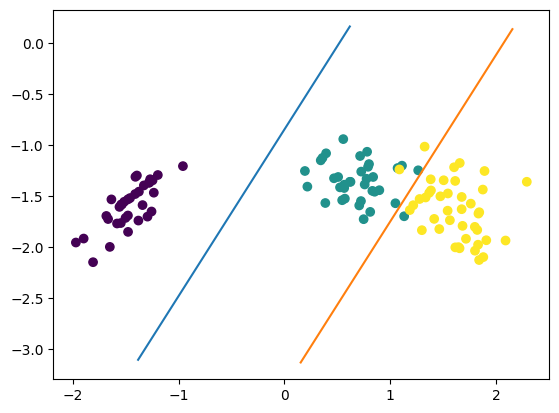

In [14]:
# plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train)
# plt.show()

W = LDA_dimensionality(X_train, y_train, 2)
X_new = np.dot((X_train), W)
X_new = np.real(X_new)
plt.scatter(X_new[:, 0], X_new[:, 1], marker='o', c=y_train)

# Средние значения для (x, y) каждого класса
middle_points = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(y_train)):
    middle_points[y_train[i]][0] += X_new[i, 0]
    middle_points[y_train[i]][1] += X_new[i, 1]
    middle_points[y_train[i]][2] += 1
middle_points = [[elem[0]/elem[2], elem[1]/elem[2]] for elem in middle_points]
print(middle_points)

func = []
for i in range(len(middle_points) - 1): # прямых на 1 меньше чем классов
    x = (middle_points[i][0] + middle_points[i + 1][0]) / 2
    y = (middle_points[i][1] + middle_points[i + 1][1]) / 2
    W_new = np.real(W)
    k = sum(W_new[:, 0]) - sum(W_new[:, 1])
    b = y - x * k
    f = lambda x: k * x + b 

    x_line = [x - 1, x + 1]
    y_line = [f(i) for i in x_line]
    plt.plot(x_line, y_line)
    func.append([k, b])


plt.show()

In [15]:
X_new_test = np.dot((X_test), W)

Оценка эффективности работы линейного дискриминативного анализа (реализация с семинара)

In [16]:
def check_ans(point, ans, func=func):
#    если выше первой прямой, то точка принадлежит к 0 или 1 классу 
    if point[1] >= func[1][0] * point[0] + func[1][1]:
        #    если выше нулевой прямой, то точка принадлежит к 0 классу 
        if point[1] >= func[0][0] * point[0] + func[0][1]:
            return ans == 0
        return ans == 1
    return ans == 2

sum(check_ans(X_new_test[i], y_test[i]) for i in range(len(X_new_test))) / len(X_new_test)

0.9473684210526315

Сравнение метода LDA из sklearn.discriminant_analysis

In [17]:
clf = LinearDiscriminantAnalysis()
pred = clf.fit(X_train, y_train).predict(X_test)
print(f'Rifht ans: {sum(pred[i] == y_test[i] for i in range(len(y_test))) / len(y_test)}')

Rifht ans: 0.9473684210526315


Чтобы алгоитм работал эффективнее можно изменить параметры классификатора. Добавлен параметр solver='eigen' при котором разложение происходит по собственным значениям. Так же был добавлен параметр shrinkage с некоторым значением сжатия

In [18]:
clf = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.9)
pred = clf.fit(X_train, y_train).predict(X_test)
print(f'Rifht ans: {sum(pred[i] == y_test[i] for i in range(len(y_test))) / len(y_test)}')

Rifht ans: 0.9736842105263158


Таким образом, реализация sklearn.discriminant_analysis показала более высокий процент верных ответов, чем решение с LDA рассмотренным на семинаре